# CloneSig package
In this notebook, we show a few of CloneSig's main functions, and the associated parameters that can be tuned in order to adjust the results if needed. Runtime should be in the range of minutes on a personal computer (see runtimes for each cell); of course runtime increases when the number of mutations increases.

## Data simulation

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
from seaborn.distributions import _freedman_diaconis_bins

from clonesig.data_loader import SimLoader
from clonesig.run_clonesig import get_MU, run_clonesig

sns.set_context('poster')

running on server, otherwise please investigate
running on server, otherwise please investigate
running on server, otherwise please investigate


The class ```SimLoader``` is the one to use to simulate data. Several inputs are necessary
- `N`, the number of wanted mutations
- `J`, the number of clones
Other parameters are **optional** and provide further control over the simulated tumor sample.
- `inputMU` is the input signature matrix, containing $L$ signatures, and of size $L\times K$, with $K$ the number of possible mutation type (typically 96)
- `xi_param`, `pi_param`, `phi_param`, `rho_param`, `purity_param` allow the user to set values for parameters of the model $\xi, \pi, \phi, \rho$ and the purity. Some of them allow some indications for the simulation (see [class docstring](https://github.com/judithabk6/clonesig/blob/master/clonesig/data_loader.py#L108) for more details)
- `change_sig_activity` is a boolean indicating whether the signature activity should be constant between the clones
- `dip_prop` indicates the proportion of the simulated genome (mutations) that should be diploid

Then two methods must be called to assign the parameters and simulate the mutations, and finally, several methods to get a table describing the mutations (that can be used as input to fit CloneSig's model).

In [2]:
N = 2000
J = 3


sim_object = SimLoader(N, J, rho_param=100, cn=False)
sim_object._get_unobserved_nodes()
sim_object._get_observed_nodes()
# to get the mutation table
sim_mutation_table = sim_object._get_data_df()
sim_mutation_table.head()

,mutation_id,chromosome,position,ref_counts,var_counts,normal_cn,minor_cn,mut_cn,major_cn,total_cn,trinucleotide,signature,clone
0,mut_1,1,5,396.0,119.0,2.0,1.0,1.0,1.0,2.0,31,16,1
1,mut_2,1,15,44.0,24.0,2.0,1.0,1.0,1.0,2.0,66,56,0
2,mut_3,1,25,127.0,35.0,2.0,1.0,1.0,1.0,2.0,90,64,1
3,mut_4,1,35,50.0,24.0,2.0,1.0,1.0,1.0,2.0,6,56,0
4,mut_5,1,45,245.0,125.0,2.0,1.0,1.0,1.0,2.0,95,64,1


We can represent the simulated data (here the true CCF for each mutation - unknown in the case of real data)

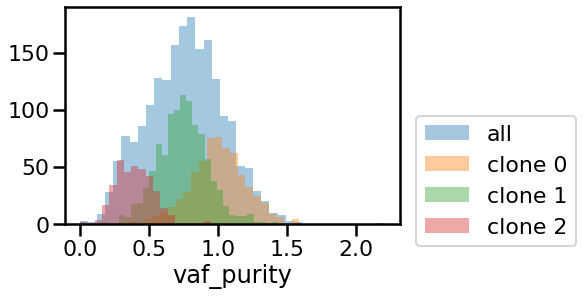

In [26]:
purity = sim_object.purity
sim_mutation_table = sim_mutation_table.assign(vaf=sim_mutation_table.var_counts /
                         (sim_mutation_table.ref_counts + sim_mutation_table.var_counts))
sim_mutation_table = sim_mutation_table.assign(
    total_cn=lambda x: x['minor_cn'] + x['major_cn'])
sim_mutation_table = sim_mutation_table.assign(
    vaf_cn=sim_mutation_table.vaf * sim_mutation_table['total_cn'] / sim_mutation_table['mut_cn'])
sim_mutation_table = sim_mutation_table.assign(
    vaf_purity=sim_mutation_table.apply(
        lambda x: x['vaf']/purity *
        ((1 - purity) * 2 + purity * x['total_cn']) /
        x['mut_cn'], axis=1))

# save data to provide an example csv
sim_mutation_table.to_csv('example_data.csv', index=False)
with open('purity.txt', 'w') as f:
    f.write('{}'.format(purity))

sns.distplot(sim_mutation_table.vaf_purity, kde=False, label='all')
for i in range(J):
    sns.distplot(sim_mutation_table[sim_mutation_table.clone==i].vaf_purity, kde=False, label='clone {}'.format(i))
plt.legend(bbox_to_anchor=(1.05, 0.5), loc=2, borderaxespad=0.)


Text(0.5, -21.5, 'signature index')

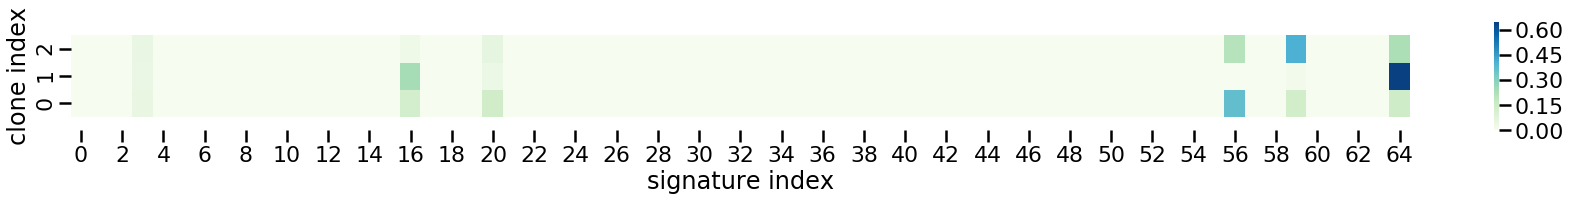

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(30, 2))
sns.heatmap(sim_object.pi, vmin=0, vmax=np.max(sim_object.pi), ax=ax, cmap='GnBu', annot=False, fmt='.2f', annot_kws={"size": 12})
ax.set_ylim((-0.5, 3.5))
ax.set_ylabel('clone index')
ax.set_xlabel('signature index')

## Running CloneSig on that simulated sample

### run CloneSig

The model fitting step of CloneSig is handled by the class [Estimator](https://github.com/judithabk6/clonesig/blob/master/clonesig/estimator.py#L50). However the complete pipeline includes other important step such as selecting the number of clones, apply the statistical test to determine the significance of a signature change between the different clones. All those steps are wrapped in a single function, [run_clonesig](https://github.com/judithabk6/clonesig/blob/master/clonesig/run_clonesig.py#L322). The principal inputs taken by the function are
- `T` : iterable of length N with the trinucleotide context of each mutation, numbered from 0 to 95
- `B` : iterable of length N with the variant allele read count for each mutation
- `D` : iterable of length N with the total read count for each mutation
- `C_normal` : iterable of length N copy number of non-tumor cells in the sample at each mutation locus
- `C_tumor_tot`  : iterable of length N the total copy number of tumor cells in the sample at each mutation locus
- `C_tumor_minor` : iterable of length N the minor copy number of tumor cells in the sample at each mutation locus. If this info is not available, set it to zero so that clonesig considers all possible genotypes
- `purity` : float in [0, 1] an estimate of the tumor purity of the sample
- `inputMU` : array-like (L, 96) known L signatures to be fit by clonesig.

Ohter options are available and are detailed in the doctstring of the function. `run_clonesig` returns several 
new_est, lr, p, new_inputMU, cst_est, future_sigs
- the Estimator object
- the log ratio of the statistical test (statistrics)
- the associated pvalue
- the MU matrix used for the fit (useful in the case where `run_clonesig` is used in the prefit mode where a first run preselects a subset of signatures that will subsequently be fit to the data
- the alternative Estimator object with a constant signature mixture constant across all clones
- a boolean vector describing the signatures retained or not for fit in the case where the "prefit" option is used.


In [5]:
default_MU = get_MU()
print('size of the default MU matrix:', default_MU.shape)

est, lr, pval, new_inputMU, cst_est, future_sigs = run_clonesig(
    np.array(sim_mutation_table.trinucleotide),
    np.array(sim_mutation_table.var_counts),
    np.array(sim_mutation_table.var_counts + sim_mutation_table.ref_counts),
    np.array(sim_mutation_table.normal_cn),
    np.array(sim_mutation_table.total_cn),
    np.array(sim_mutation_table.total_cn - sim_mutation_table.major_cn),
    sim_object.purity, default_MU)





size of the default MU matrix: (65, 96)
0 0
1 0
2 0
3 0
4 0
stopped and chosen number of clones is  3
[-14213.70515971 -14138.04500238 -14061.97400585 -14061.32232777
 -14061.46099665      0.              0.              0.        ]
[-14230.25992527 -14171.1545335  -14111.63830252 -14127.54139
 -14144.23482444      0.              0.              0.        ]
stopped and chosen number of clones is  3
[-14213.70515971 -14138.04500238 -14061.97400585 -14061.32232777
 -14061.46099665      0.              0.              0.        ]
[-14230.25992527 -14171.1545335  -14111.63830252 -14127.54139
 -14144.23482444      0.              0.              0.        ]
(3, 65) (65, 96) 3


### Compare CloneSig results with simulations

In [6]:
est_table = pd.DataFrame({'trinucleotide': est.T, 'var_counts': est.B,
                          'minor_cn': est.C_tumor_minor,
                          'major_cn': est.C_tumor_major,
                          'total_cn': est.C_tumor_tot, 'depth': est.D,
                          'clone': est.qun.argmax(axis=1),
                          'signature': np.arange(default_MU.shape[0])[est.rnus[np.arange(est.N), est.qun.argmax(axis=1), :].argmax(axis=1)],
                          'mult': est.vmnu[np.arange(est.N), est.qun.argmax(axis=1), :].argmax(axis=1) +1})
est_table = est_table.assign(vaf=est_table.var_counts / est_table.depth)
est_table = est_table.assign(vaf_cn=est_table.vaf * est_table['total_cn'] / est_table['mult'])
est_table = est_table.assign(vaf_purity=est_table.apply(lambda x: x['vaf']/est.p * ((1 - est.p) * 2 + est.p * x['total_cn']) / x['mult'], axis=1))
nb_bins = min(_freedman_diaconis_bins(est_table.vaf_purity) * 2, 50)
final_bins = np.linspace(min(est_table.vaf_purity), max(est_table.vaf_purity), nb_bins)

est_table = est_table.assign(trinucleotide=pd.Categorical(est_table.trinucleotide, ordered=True, categories=range(96)))


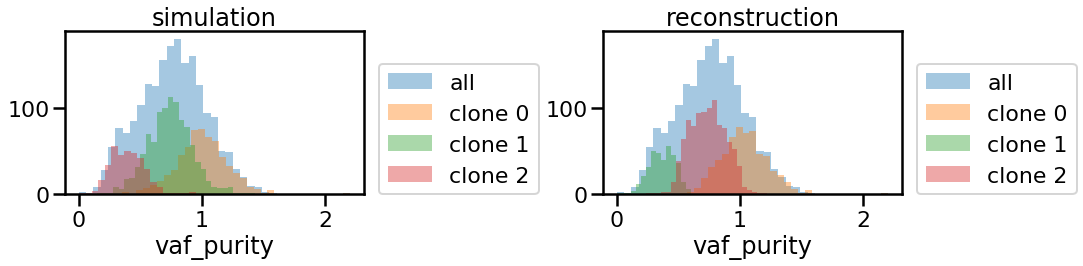

In [7]:
fig, ax = plt.subplots(ncols=2, figsize=(15,3))

sns.distplot(sim_mutation_table.vaf_purity, kde=False, label='all', ax=ax[0])
for i in range(J):
    sns.distplot(sim_mutation_table[sim_mutation_table.clone==i].vaf_purity, kde=False, label='clone {}'.format(i), ax=ax[0])
ax[0].legend(bbox_to_anchor=(1.05, 0.8), loc=2, borderaxespad=0.)
ax[0].set_title('simulation')

sns.distplot(est_table.vaf_purity, kde=False, label='all', ax=ax[1])
for i in range(est.J):
    sns.distplot(est_table[est_table.clone==i].vaf_purity, kde=False, label='clone {}'.format(i), ax=ax[1])
plt.legend(bbox_to_anchor=(1.05, 0.8), loc=2, borderaxespad=0.)
ax[1].set_title('reconstruction')
plt.subplots_adjust(wspace = 0.8)



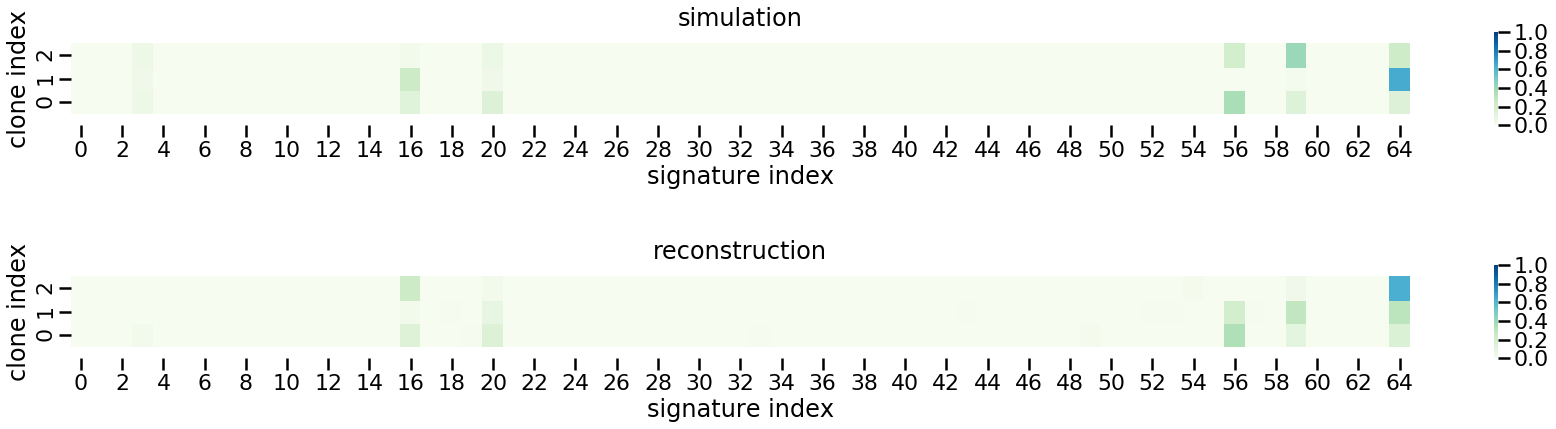

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(30, 6))
sns.heatmap(sim_object.pi, vmin=0, vmax=1, ax=ax[0], cmap='GnBu')
sns.heatmap(est.pi, vmin=0, vmax=1, ax=ax[1], cmap='GnBu')

ax[0].set_ylim((-0.5, 3.5))
ax[0].set_ylabel('clone index')
ax[0].set_xlabel('signature index')
ax[0].set_title('simulation')

ax[1].set_ylim((-0.5, 3.5))
ax[1].set_ylabel('clone index')
ax[1].set_xlabel('signature index')
ax[1].set_title('reconstruction')

plt.subplots_adjust(hspace = 1.5)

### Alternative parameters to adjust
#### the input signatures
You can use a subset of signatures as input, either by manually select the ones you want from from the default matrix provided by the function `get_MU`, or by use the match of cancer-type-signature provided in Alexandrov's package SigProfiler (see [this script](https://github.com/judithabk6/Clonesig_analysis/blob/master/signature_code/sigprofiler_alexandrov18_data.py) for the precise procedure). In that case you can provide to `get_MU` the parameter `cancer_type` with an integer, indexing the wanted cancer types. Here is the list of the 65 signatures considered in the COSMIC v3 version


>Signature Subs-01, Signature Subs-02, Signature Subs-03, Signature Subs-04, Signature Subs-05, Signature Subs-06, Signature Subs-07a, Signature Subs-07b, Signature Subs-07c, Signature Subs-07d, Signature Subs-08, Signature Subs-09, Signature Subs-10a, Signature Subs-10b, Signature Subs-11, Signature Subs-12, Signature Subs-13, Signature Subs-14, Signature Subs-15, Signature Subs-16, Signature Subs-17a, Signature Subs-17b, Signature Subs-18, Signature Subs-19, Signature Subs-20, Signature Subs-21, Signature Subs-22, Signature Subs-23, Signature Subs-24, Signature Subs-25, Signature Subs-26, Signature Subs-27, Signature Subs-28, Signature Subs-29, Signature Subs-30, Signature Subs-31, Signature Subs-32, Signature Subs-33, Signature Subs-34, Signature Subs-35, Signature Subs-36, Signature Subs-37, Signature Subs-38, Signature Subs-39, Signature Subs-40, Signature Subs-41, Signature Subs-42, Signature Subs-43, Signature Subs-44, Signature Subs-45, Signature Subs-46, Signature Subs-47, Signature Subs-48, Signature Subs-49, Signature Subs-50, Signature Subs-51, Signature Subs-52, Signature Subs-53, Signature Subs-54, Signature Subs-55, Signature Subs-56, Signature Subs-57, Signature Subs-58, Signature Subs-59, Signature Subs-60



Available types are

|Cancer type | index | 
|--- | --- |
| BILIARY-ADENOCA    |     0|
| BLADDER-TCC        |     1|
| BONE-BENIGN        |     2|
| BONE-EPITH         |     3|
| BONE-OSTEOSARC     |     4|
| BREAST-ADENOCA     |     5|
| BREAST-LOBULARCA   |     6|
| CERVIX-ADENOCA     |     7|
| CERVIX-SCC         |     8|
| CNS-GBM            |     9|
| CNS-MEDULLO        |    10|
| CNS-OLIGO          |    11|
| CNS-PILOASTRO      |    12|
| COLORECT-ADENOCA   |    13|
| ESO-ADENOCA        |    14|
| HEAD-SCC           |    15|
| KIDNEY-CHRCC       |    16|
| KIDNEY-RCC         |    17|
| LIVER-HCC          |    18|
| LUNG-ADENOCA       |    19|
| LUNG-SCC           |    20|
| LYMPH-BNHL         |    21|
| LYMPH-CLL          |    22|
| MYELOID-AML        |    23|
| MYELOID-MPN        |    24|
| OVARY-ADENOCA      |    25|
| PANC-ADENOCA       |    26|
| PANC-ENDOCRINE     |    27|
| PROST-ADENOCA      |    28|
| SKIN-MELANOMA      |    29|
| SOFTTISSUE-LEIOMYO |    30|
| SOFTTISSUE-LIPOSARC|    31|
| STOMACH-ADENOCA    |    32|
| THY-ADENOCA        |    33|
| UTERUS-ADENOCA     |    34| 


You can also use the v2 signatures, by specifying the parameter `cosmic_version=2`, and in that case, the matching of cancer types and signatures is given by

|Cancer type | index | 
|--- | --- |
| Adrenocortical carcinoma    |     0 |
| ALL                         |     1 |
| AML                         |     2 |
| Bladder                     |     3 |
| Breast                      |     4 |
| Cervix                      |     5 |
| Chondrosarcoma              |     6 |
| CLL                         |     7 |
| Colorectum                  |     8 |
| Glioblastoma                |     9 |
| Glioma Low Grade            |    10 |
| Head and Neck               |    11 |
| Kidney Chromophobe          |    12 |
| Kidney Clear Cell           |    13 |
| Kidney Papillary            |    14 |
| Liver                       |    15 |
| Lung Adeno                  |    16 |
| Lung Small Cell             |    17 |
| Lung Squamous               |    18 |
| Lymphoma B-cell             |    19 |
| Lymphoma Hodgkin            |    20 |
| Medulloblastoma             |    21 |
| Melanoma                    |    22 |
| Myeloma                     |    23 |
| Nasopharyngeal Carcinoma    |    24 |
| Neuroblastoma               |    25 |
| Oesophagus                  |    26 |
| Oral gingivo-buccal squamous|    27 |
| Osteosarcoma                |    28 |
| Ovary                       |    29 |
| Pancreas                    |    30 |
| Paraganglioma               |    31 |
| Pilocytic Astrocytoma       |    32 |
| Prostate                    |    33 |
| Stomach                     |    34 |
| Thyroid                     |    35 |
| Urothelial Carcinoma        |    36 |
| Uterine Carcinoma           |    37 |
| Uterine Carcinosarcoma      |    38 |
| Uveal Melanoma              |    39 |


#### selection of the number of clones
the default behavior corresponds to the heuristics fitted with simulations. However, one can change the parameter for the adapted BIC using the parameter `model_selection_kws`.

108.25658168252099